# Описание проекта: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

Задача — обучить на этих данных модель для прогноза оттока клиентов.

## Описание услуг

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

##  Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Файл **contract_new.csv**
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл **personal_new.csv**

- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл **internet_new.csv**

- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл **phone_new.csv**

- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.
Данные также находятся в тренажёре, в папке /datasets/.

In [1]:
# библиотеки
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
import time
import re
import nltk
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
# инструменты
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool

In [2]:
try:
    import phik
except:
    !pip install phik
    import phik

In [3]:
RANDOM_STATE=20924

## Загрузка данных

In [4]:
try:
    contract_new_data = pd.read_csv('/datasets/contract_new.csv')
except FileNotFoundError:
    contract_new_data = pd.read_csv('C:\\Users\Anna\Desktop\practikum\contract_new.csv')

In [5]:
contract_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contract_new_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
try:
    personal_new_data = pd.read_csv('/datasets/personal_new.csv')
except FileNotFoundError:
    contract_new_data = pd.read_csv('C:\\Users\Anna\Desktop\practikum\personal_new.csv')

In [8]:
personal_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
personal_new_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
try:
    internet_new_data = pd.read_csv('/datasets/internet_new.csv')
except FileNotFoundError:
    internet_new_data = pd.read_csv('C:\\Users\Anna\Desktop\practikum\internet_new.csv')

In [11]:
internet_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [12]:
internet_new_data.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
try:
    phone_new_data = pd.read_csv('/datasets/phone_new.csv')
except FileNotFoundError:
    phone_new_data = pd.read_csv('C:\\Users\Anna\Desktop\practikum\phone_new.csv')

In [14]:
phone_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [15]:
phone_new_data.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Вывод**

Выполнена загрузка и первичный осмотр данных:
- В датасете contract_new 7043 записей
- В датасете personal_new 7043 записей
- В датасете internet_new 5517 записей
- В датасете phone_new 6361 записей

## Исследовательский анализ и предобработка данных

Проверим данные на дубликаты.

In [16]:
contract_new_data.duplicated().sum()

0

In [17]:
personal_new_data.duplicated().sum()

0

In [18]:
internet_new_data.duplicated().sum()

0

In [19]:
phone_new_data.duplicated().sum()

0

Дубликатов не обнаружено.

Проверим пропуски в данных.

In [20]:
contract_new_data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [21]:
personal_new_data.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [22]:
internet_new_data.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [23]:
phone_new_data.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

Пропусков не обнаружено.

Поле **BeginDate** необходимо привести к типу datetime

Поле **EndDate** – это целевой признак, любая дата в этом поле соответствует уходу клиента, если стоит значение "No" - клиент остался.
Для значения "No" можно установить уникальную дату (например, дату актуальности датасета - 2020-02-01), после чего привести поле к формату datetime;

In [24]:
contract_new_data['EndDate'] = contract_new_data['EndDate'].replace(['No'], ['2020-02-01'])

In [25]:
contract_new_data['BeginDate'] = pd.to_datetime(contract_new_data['BeginDate'],format = '%Y-%m-%d')
contract_new_data['EndDate'] = pd.to_datetime(contract_new_data['EndDate'],format = '%Y-%m-%d')

**Вывод**

- Дубликатов и пропусков не обнаружено
- Поля BeginDate и EndDate приведены к типу datetime
- В поле EndDate добавлена заглушка (вместо No теперь значение '2020-02-01')

## Объединение данных

In [26]:
df_telecom = contract_new_data.set_index('customerID').join(phone_new_data.set_index('customerID'))
df_telecom = df_telecom.join(personal_new_data.set_index('customerID'))
df_telecom = df_telecom.join(internet_new_data.set_index('customerID'))

In [27]:
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   MultipleLines     6361 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

Закодируем бинарные признаки.

In [28]:
df_telecom.head(20)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,NaN,Female,0,Yes,No,DSL,No,Yes,No,No,No,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,NaN,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No
9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Yes,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Yes,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,NaN,Female,0,No,No,DSL,Yes,No,No,No,No,No
7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Yes,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes


In [29]:
df_telecom.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00


**Вывод**

- Выполнено объединение датасетов contract_new_data, personal_new_data, internet_new_data (итоговый датасет df_telecom)
- Закодированы признаки MultipleLines, 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Partner', 'Dependents'
- Значения NaN заполнены No

## Исследовательский анализ и предобработка данных объединённого датафрейма

Построим распределение значений ежемесячных трат и соотнесем его с уходом клиентов

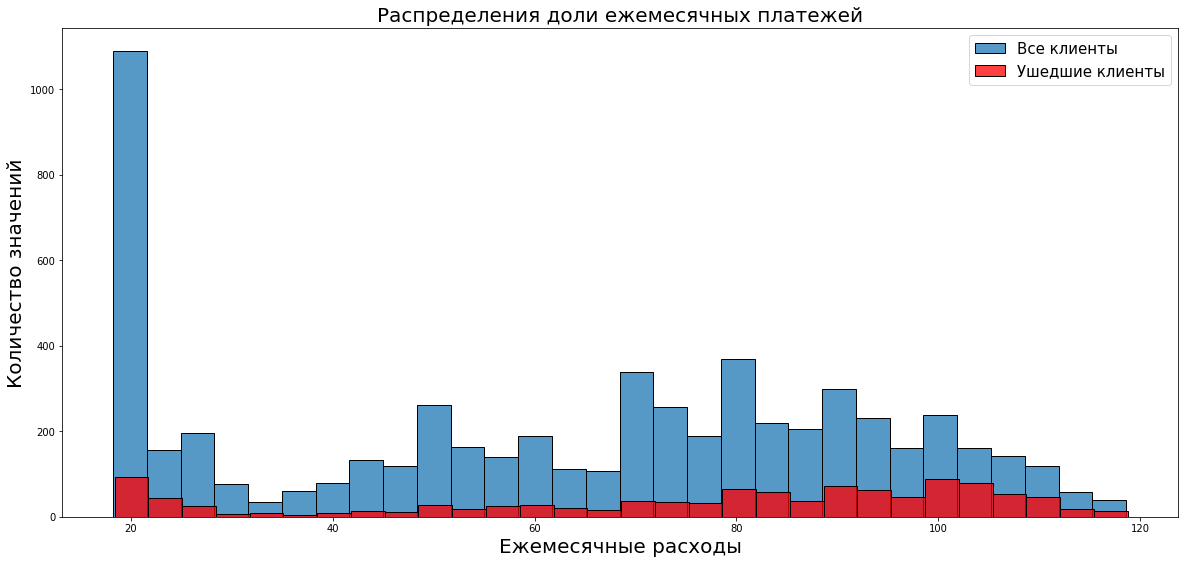

In [30]:
f, axes = plt.subplots(1, 1, figsize=(20, 9))
axes.set_title('Распределения доли ежемесячных платежей', fontsize=20)
axes.set_ylabel('Количество значений', fontsize=20)
sns.histplot(df_telecom[df_telecom['EndDate'] == '2020-02-01']['MonthlyCharges'], bins=30)
sns.histplot(df_telecom[df_telecom['EndDate'] != '2020-02-01']['MonthlyCharges'], bins=30, color = 'red')
axes.set_xlabel('Ежемесячные расходы', fontsize=20)
axes.legend(labels=["Все клиенты","Ушедшие клиенты"], fontsize=15);

По графику видно, что у большого количества ушедших пользователей были большие ежемесячные расходы.  

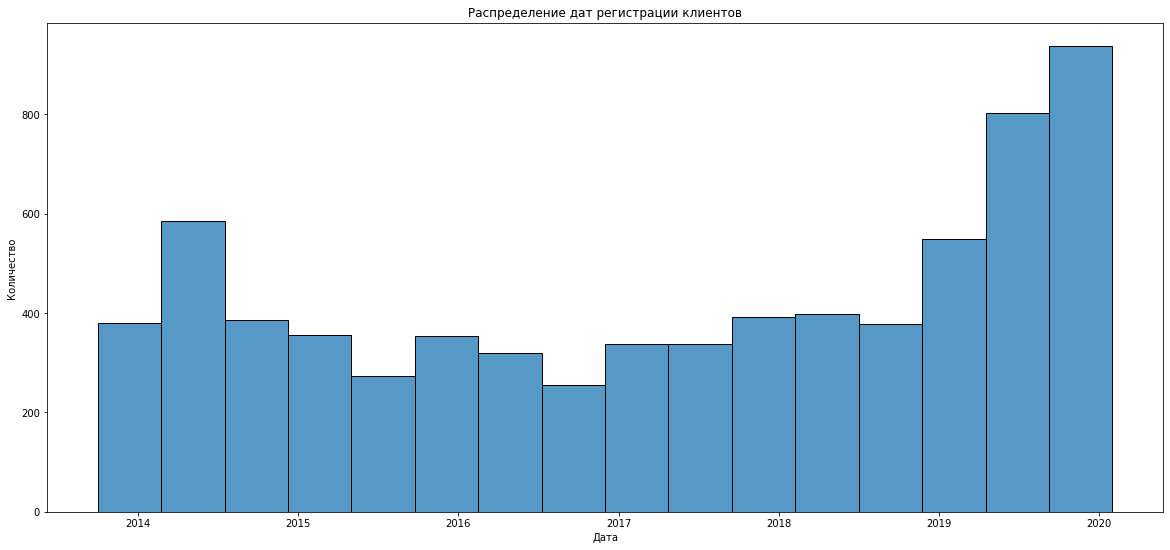

In [31]:
f, axes = plt.subplots(1, 1, figsize=(20, 9))
sns.histplot(df_telecom['BeginDate'])
plt.title('Распределение дат регистрации клиентов')
plt.xlabel('Дата')
plt.ylabel('Количество');

Видно, что примерно в середине 2014 года было зарегистрированно много пользователей, потом до 2019 видно снижение количества, и пик мы видим в 2020 году.

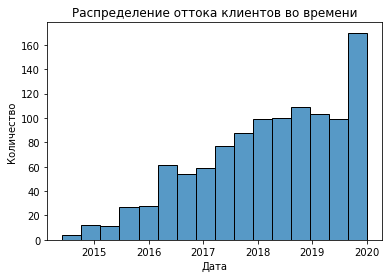

In [32]:
sns.histplot(df_telecom.query('EndDate != "2020-02-01"')['EndDate'])
plt.title('Распределение оттока клиентов во времени')
plt.xlabel('Дата')
plt.ylabel('Количество');

Видно, что в основном клиенты начали уходить с 2017 года. В 2020 году наблюдаем пик ухода клиентов.

Добавим признак: длительность (в днях) пользования клиентом услугами компании

In [33]:
df_telecom['TotalTime'] = (df_telecom['EndDate'] - df_telecom['BeginDate']).dt.days

In [34]:
# Удалим пользователей, у которых суммарное число дней контракта равно 0 дней,так как их доля меньше 1 процента
df_telecom = df_telecom[df_telecom['TotalTime'] != 0]

In [35]:
#  Заменим все пропущенные значения на No
def data_fillna (data:pd.DataFrame, colname: str):
    data[colname] = data[colname].fillna('No')

In [36]:
list_cols_to_fillna = ['InternetService',
                'OnlineSecurity',
                'OnlineBackup',
                'DeviceProtection',
                'TechSupport',
                'StreamingTV',
                'StreamingMovies',
              'MultipleLines']
for elem in list_cols_to_fillna:
    data_fillna(df_telecom, elem)

In [37]:
df_telecom["TotalCharges"] = df_telecom["TotalCharges"].astype('float')

In [38]:
df_telecom

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,TotalTime
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,No,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,No,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,Yes,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,730
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,Yes,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,2191
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,No,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,337


In [39]:
df_telecom.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
MultipleLines       0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
TotalTime           0
dtype: int64

Можно выделить целевой признак:

In [40]:
df_telecom['escape_client'] = df_telecom['EndDate'] != "2020-02-01"

In [41]:
df_telecom = df_telecom.drop(('BeginDate'), axis=1)
df_telecom = df_telecom.drop(('EndDate'), axis=1)

Посмотрим распределение времени, сколько ушедшие клиенты пользовались услугами компании

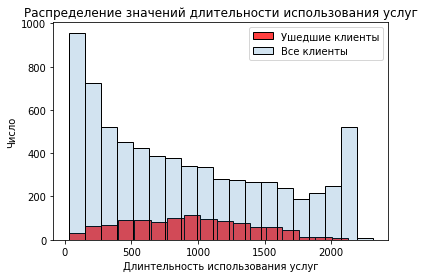

In [42]:
ax = sns.histplot(df_telecom.query('escape_client == 1')['TotalTime'],
                  color='red',
                  label='Ушедшие клиенты')
sns.histplot(df_telecom['TotalTime'],
             ax=ax,
             alpha=0.2,
             label='Все клиенты')
ax.legend()
plt.title('Распределение значений длительности использования услуг')
plt.xlabel('Длинтельность использования услуг')
plt.ylabel('Число');

У ушедших пользователей средняя длительность пользования услугами в два раза меньше, чем у тех, которые остались.

**Вывод**
- У большого количества ушедших пользователей были большие ежемесячные расходы
- Примерно в середине 2014 года было зарегистрированно много пользователей, потом до 2019 видно снижение количества, и пик мы видим в 2020 году
- Заполнены пропуски в поле TotalCharges
- В основном клиенты начали уходить с 2017 года. В 2020 году наблюдаем пик ухода клиентов.
- У ушедших пользователей средняя длительность пользования услугами в два раза меньше, чем у оставшихся.

## Подготовка данных

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'TotalTime']


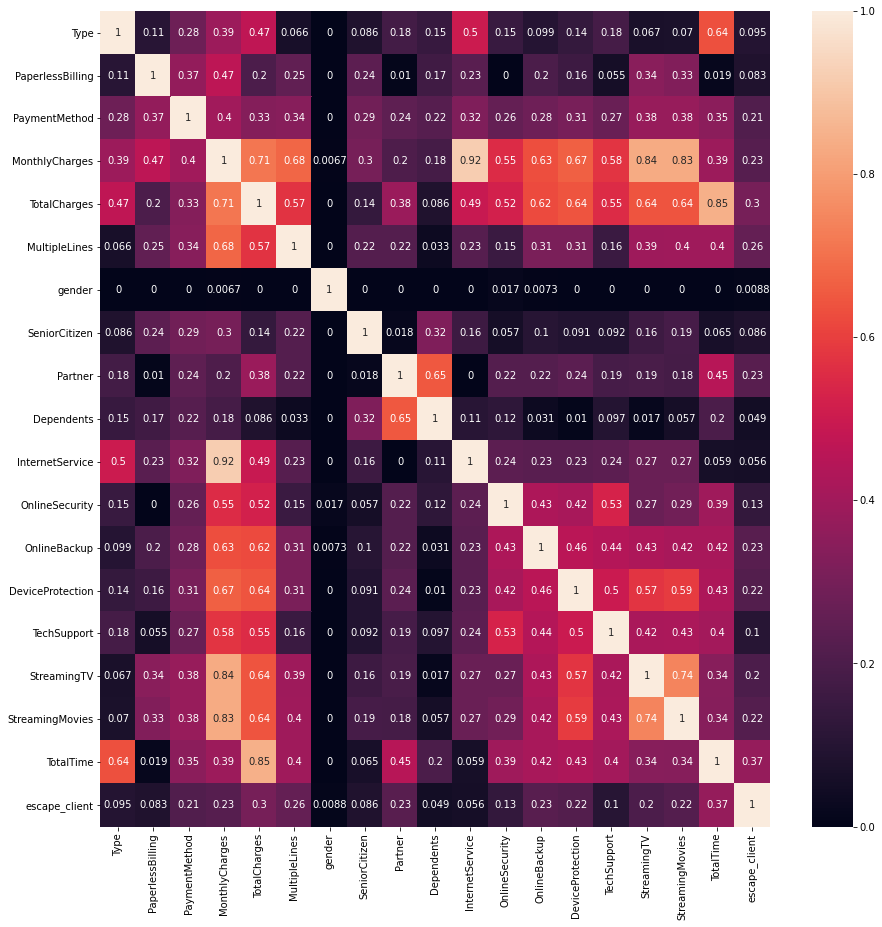

In [43]:
phik_matr = df_telecom.phik_matrix()
plt.figure(figsize=(15, 15))
sns.heatmap(phik_matr, annot=True);

Видна связь между признаками:
- TotalCharges и TotalTime
- MonthlyCharges и InternetService, StreamingTV, StreamingMovies.

In [44]:
categories = ["Type", "PaperlessBilling", "SeniorCitizen", "PaymentMethod", "gender", "MultipleLines",
       "SeniorCitizen", "Partner", "Dependents", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
             "TechSupport", "StreamingTV", "StreamingMovies"]

In [45]:
print("Уникальные значения столбцов:")
for col in categories:
    print(col, "-", df_telecom[col].unique())

Уникальные значения столбцов:
Type - ['Month-to-month' 'One year' 'Two year']
PaperlessBilling - ['Yes' 'No']
SeniorCitizen - [0 1]
PaymentMethod - ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
gender - ['Female' 'Male']
MultipleLines - ['No' 'Yes']
SeniorCitizen - [0 1]
Partner - ['Yes' 'No']
Dependents - ['No' 'Yes']
InternetService - ['DSL' 'Fiber optic' 'No']
OnlineSecurity - ['No' 'Yes']
OnlineBackup - ['Yes' 'No']
DeviceProtection - ['No' 'Yes']
TechSupport - ['No' 'Yes']
StreamingTV - ['No' 'Yes']
StreamingMovies - ['No' 'Yes']


In [46]:
df_telecom["escape_client"] = df_telecom["escape_client"].astype(int)

In [47]:
train, test = train_test_split(df_telecom, test_size=0.25, random_state=RANDOM_STATE, stratify=df_telecom["escape_client"])

In [48]:
X_train = train.drop("escape_client", axis=1)
y_train = train["escape_client"]

X_test = test.drop("escape_client", axis=1)
y_test = test["escape_client"]

## Обучение моделей машинного обучения

In [49]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5274, 18), (5274,), (1758, 18), (1758,))

In [50]:
categorical = ["Type", "PaperlessBilling", "PaymentMethod", "MultipleLines",
              "gender", "SeniorCitizen", "Partner", "Dependents", "InternetService",
             "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
              "StreamingTV", "StreamingMovies"]

In [51]:
%%time

pipe_cb = Pipeline([("model", CatBoostClassifier(cat_features=categorical, 
                                                 random_state=RANDOM_STATE))])

parametrs_cb = {"model__logging_level": ["Silent"], 
                "model__learning_rate": [0.3], 
                "model__iterations": [1000], 
                "model__depth": [2], 
                "model__eval_metric": ["AUC"], 
                "model__auto_class_weights": ["Balanced"]}

model_cb = GridSearchCV(estimator=pipe_cb, 
                        param_grid=parametrs_cb, 
                        scoring=["roc_auc", "accuracy"], 
                        refit="roc_auc", 
                        n_jobs=-1)

start_cb = time.time()
model_cb.fit(X_train, y_train)
fit_time_cb = round(time.time() - start_cb, 3)

print("Время обучения модели:", fit_time_cb)

Время обучения модели: 24.728
CPU times: user 19.6 s, sys: 757 ms, total: 20.4 s
Wall time: 24.7 s


In [52]:
model_cb.best_params_

{'model__auto_class_weights': 'Balanced',
 'model__depth': 2,
 'model__eval_metric': 'AUC',
 'model__iterations': 1000,
 'model__learning_rate': 0.3,
 'model__logging_level': 'Silent'}

In [53]:
roc_auc_cb = model_cb.cv_results_["mean_test_roc_auc"].max()

In [54]:
features = df_telecom.drop('escape_client', axis=1)
target = df_telecom['escape_client']

In [55]:
numerics = list(features.select_dtypes(include=['int64', 'float64']).columns)

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

col_transformer.fit(X_train)
features_train = col_transformer.transform(X_train)
features_test = col_transformer.transform(X_test)

In [82]:
X_train

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,TotalTime
customerID,,,,,,,,,,,,,,,,,,
5174-RNGBH,Month-to-month,No,Mailed check,66.25,842.70,No,Female,0,No,No,DSL,No,Yes,No,Yes,Yes,No,365
9272-LSVYH,Month-to-month,No,Mailed check,70.15,701.50,No,Male,0,No,No,Fiber optic,No,No,No,No,No,No,306
0823-HSCDJ,Month-to-month,Yes,Electronic check,49.15,1875.56,No,Male,1,No,No,DSL,No,Yes,No,No,Yes,Yes,1096
1830-GGFNM,Two year,No,Credit card (automatic),94.55,3120.15,Yes,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,1004
5159-YFPKQ,Month-to-month,Yes,Electronic check,75.80,241.04,No,Female,0,No,No,Fiber optic,No,No,Yes,No,No,No,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0621-CXBKL,Two year,No,Mailed check,18.70,991.10,No,Female,0,No,No,No,No,No,No,No,No,No,1614
5242-UOWHD,Two year,No,Mailed check,20.35,952.38,No,Male,0,Yes,Yes,No,No,No,No,No,No,No,1371
4998-IKFSE,Month-to-month,No,Electronic check,100.45,3013.50,Yes,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,914


In [56]:
pipe_logreg = Pipeline([
    ('regression', LogisticRegression(max_iter=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=1))
])

In [57]:
params_logreg = {
    'regression__C': np.geomspace(0.1, 20,20)
}

In [58]:
search_logreg = GridSearchCV(
    pipe_logreg,
    param_grid=params_logreg,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [59]:
search_logreg.fit(features_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END regression__C=0.1; accuracy: (train=0.705, test=0.688) roc_auc: (train=0.776, test=0.755) total time=   0.9s
[CV 2/5] END regression__C=0.1; accuracy: (train=0.706, test=0.715) roc_auc: (train=0.769, test=0.784) total time=   1.5s
[CV 3/5] END regression__C=0.1; accuracy: (train=0.702, test=0.703) roc_auc: (train=0.772, test=0.768) total time=   0.8s
[CV 4/5] END regression__C=0.1; accuracy: (train=0.710, test=0.680) roc_auc: (train=0.772, test=0.768) total time=   1.3s
[CV 5/5] END regression__C=0.1; accuracy: (train=0.710, test=0.708) roc_auc: (train=0.778, test=0.742) total time=   0.8s
[CV 1/5] END regression__C=0.13216207294336044; accuracy: (train=0.706, test=0.687) roc_auc: (train=0.776, test=0.755) total time=   1.2s
[CV 2/5] END regression__C=0.13216207294336044; accuracy: (train=0.707, test=0.711) roc_auc: (train=0.769, test=0.784) total time=   1.1s
[CV 3/5] END regression__C=0.13216207294336044; accu

GridSearchCV(estimator=Pipeline(steps=[('regression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=200,
                                                           n_jobs=1,
                                                           random_state=20924))]),
             n_jobs=-1,
             param_grid={'regression__C': array([ 0.1       ,  0.13216207,  0.17466814,  0.23084503,  0.30508957,
        0.40321271,  0.53289427,  0.70428412,  0.93079649,  1.23015993,
        1.62580486,  2.14869741,  2.83976304,  3.7530897 ,  4.96016115,
        6.55545179,  8.66382098, 11.45028541, 15.13293455, 20.        ])},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [60]:
search_logreg.best_params_

{'regression__C': 4.960161148001825}

In [61]:
roc_auc_lr = search_logreg.best_score_

In [62]:
pipe_tree = Pipeline([
    ('tree', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])

In [63]:
params_tree = {
    'tree__max_depth': np.arange(1, 12, 2),
    'tree__min_samples_split': np.arange(2, 20, 4),
    'tree__min_samples_leaf': np.arange(1, 20, 5)
}

In [64]:
search_tree = GridSearchCV(
    pipe_tree,
    param_grid=params_tree,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [65]:
search_tree.fit(features_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END tree__max_depth=1, tree__min_samples_leaf=1, tree__min_samples_split=2; accuracy: (train=0.418, test=0.412) roc_auc: (train=0.609, test=0.602) total time=   0.0s
[CV 2/5] END tree__max_depth=1, tree__min_samples_leaf=1, tree__min_samples_split=2; accuracy: (train=0.420, test=0.420) roc_auc: (train=0.610, test=0.602) total time=   0.0s
[CV 3/5] END tree__max_depth=1, tree__min_samples_leaf=1, tree__min_samples_split=2; accuracy: (train=0.390, test=0.383) roc_auc: (train=0.603, test=0.590) total time=   0.0s
[CV 4/5] END tree__max_depth=1, tree__min_samples_leaf=1, tree__min_samples_split=2; accuracy: (train=0.377, test=0.366) roc_auc: (train=0.600, test=0.587) total time=   0.0s
[CV 5/5] END tree__max_depth=1, tree__min_samples_leaf=1, tree__min_samples_split=2; accuracy: (train=0.317, test=0.309) roc_auc: (train=0.584, test=0.568) total time=   0.0s
[CV 1/5] END tree__max_depth=1, tree__min_samples_leaf=1, tree

GridSearchCV(estimator=Pipeline(steps=[('tree',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=20924))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': array([ 1,  3,  5,  7,  9, 11]),
                         'tree__min_samples_leaf': array([ 1,  6, 11, 16]),
                         'tree__min_samples_split': array([ 2,  6, 10, 14, 18])},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [66]:
search_tree.best_params_

{'tree__max_depth': 5,
 'tree__min_samples_leaf': 11,
 'tree__min_samples_split': 2}

In [67]:
roc_auc_dtc = search_tree.best_score_

In [68]:
%%time

pipe_lgbm = Pipeline([("model", LGBMClassifier(random_state=RANDOM_STATE))])

parametrs_lgbm = {"model__max_depth": [2], 
                  "model__learning_rate": [0.3], 
                  "model__class_weight": ["balanced"]}

model_lgbm = GridSearchCV(estimator=pipe_lgbm, 
                             param_grid=parametrs_lgbm, 
                             scoring=["roc_auc", "accuracy"], 
                             refit="roc_auc", 
                             n_jobs=-1)

start_lgbm = time.time()
model_lgbm.fit(features_train, y_train)
fit_time_lgbm = round(time.time() - start_lgbm, 3)

print("Время обучения модели:", fit_time_lgbm)

Время обучения модели: 1.678
CPU times: user 1.71 s, sys: 0 ns, total: 1.71 s
Wall time: 1.68 s


In [69]:
model_lgbm.best_params_

{'model__class_weight': 'balanced',
 'model__learning_rate': 0.3,
 'model__max_depth': 2}

In [70]:
model_lgbm.best_score_

0.8604056198920469

In [71]:
grid_params = {
    'n_estimators': np.arange(40, 100, 10),
    'max_depth' : np.arange(12, 24)
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), 
                       grid_params, cv=3, scoring=['roc_auc', 'precision'], refit = 'roc_auc').fit(
    features_train, y_train)
best_rf = grid_rf.best_estimator_

In [72]:
roc_auc_rf = grid_rf.best_score_

In [73]:
analitics = pd.DataFrame(columns = ['ROC_AUC'])

def alter_table(name, roc_auc):
    analitics.loc[name, ['ROC_AUC']] = roc_auc
    return analitics

In [74]:
alter_table('CatBoostClassifier', round(roc_auc_cb, 4))
alter_table('LogisticRegression', round(roc_auc_lr, 4))
alter_table('DecisionTreeClassifier', round(roc_auc_dtc, 4))
alter_table('RandomForestClassifier', round(roc_auc_rf, 4))

,ROC_AUC
CatBoostClassifier,0.9176
LogisticRegression,0.7644
DecisionTreeClassifier,0.7876
RandomForestClassifier,0.813


**Вывод**
- Обучены четыре модели CatBoostClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
- Лучший результат (0.9176) показала модель CatBoostClassifier

## Выбор лучшей модели

In [75]:
features_test

array([[-0.31170685, -0.65587796, -0.43710057, ...,  1.        ,
         0.        ,  0.        ],
       [-0.9907603 , -0.94866126, -0.43710057, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.84052566, -0.87053314, -0.43710057, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 1.26555667,  1.096213  , -0.43710057, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.71434458, -0.83528222, -0.43710057, ...,  0.        ,
         0.        ,  1.        ],
       [-1.29459106, -0.1069317 , -0.43710057, ...,  0.        ,
         0.        ,  0.        ]])

In [76]:
# Предсказание лучшей модели
predictions = model_cb.predict(X_test)
predict_proba = model_cb.predict_proba(X_test)

In [77]:
# Расчет "ROC AUC" и времени выполнения предсказания
roc_auc = roc_auc_score(y_test, predict_proba[:, 1])
print('Показатель ROC AUC:', roc_auc)

Показатель ROC AUC: 0.9323410776681175


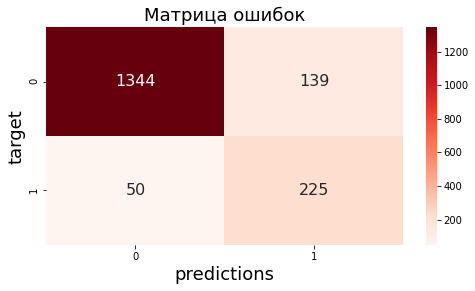

In [78]:
# Создадим матрицу ошибок CBC
cm_cbc = confusion_matrix(y_test, predictions)
cm_cbc_data = pd.DataFrame(cm_cbc,
                           index=['0', '1'],
                           columns=['0', '1'])

plt.figure(figsize=(8, 4))
sns.heatmap(cm_cbc, xticklabels=cm_cbc_data.columns, yticklabels=cm_cbc_data.index, annot=True, fmt='g', 
            cmap="Reds", annot_kws={"size": 16})
plt.title("Матрица ошибок", size=18)
plt.xlabel('predictions', size=18)
plt.ylabel('target', size=18);

In [79]:
# Анализ важности признаков
model_cb.best_estimator_[-1].feature_importances_

array([ 4.649619  ,  0.18050882,  1.91858868,  8.22099215, 11.51091955,
        1.12298321,  0.32391318,  0.36910609,  1.24612505,  0.42740378,
        0.72462794,  0.1768602 ,  0.86837089,  0.56753628,  0.44751591,
        0.11571325,  0.48574237, 66.64347365])

,importance
feature,
TotalTime,66.643474
TotalCharges,11.510920
MonthlyCharges,8.220992
Type,4.649619
PaymentMethod,1.918589
Partner,1.246125
MultipleLines,1.122983
OnlineBackup,0.868371
InternetService,0.724628


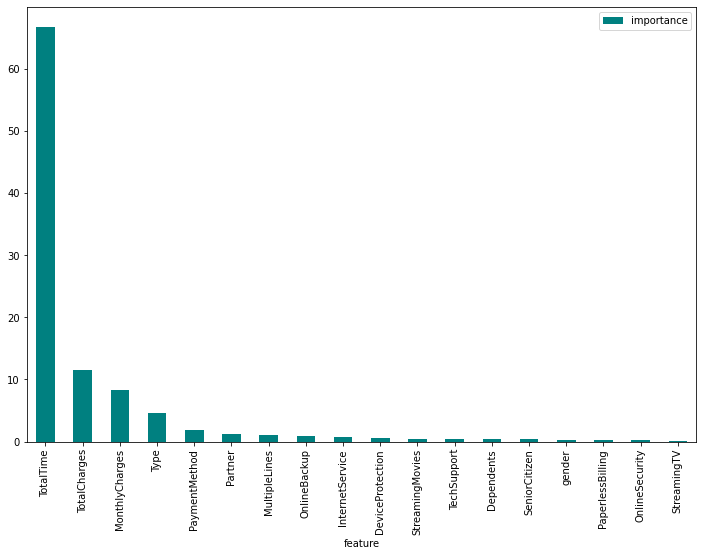

In [80]:
# исследуем важность признаков у ЛУЧШЕЙ модели

feature_importances = model_cb.best_estimator_[-1].feature_importances_
feature_names = model_cb.best_estimator_[-1].feature_names_
# Сохранение результатов в DataFrame
fi_df = pd.DataFrame({'feature': feature_names,
                      'importance': feature_importances}) \
                    .sort_values('importance', ascending = False)

# Вывод важности признаков
fi_df.set_index('feature', inplace=True)
display(fi_df.head(10))

fi_df.plot.bar(color = 'teal', figsize=(12, 8));

**Вывод**

Модель CatBoostClassifier очень хорошо показала себя на тестовых данных. По итогам предсказаний мы имеем AUC-ROC 0.9323410776681175.

Если проанализировать матрицу ошибок, то мы имеем:

- 76% от общего количества тестовых данных - правильное определение класса 0
- 3% - правильное предсказание класса 1
- 8% мы неправильно угадываем класс 0, метка предсказания - 1
- 12% мы неправильно идентифицируем человека, который не хочет уходить

## Общий вывод и рекомендации заказчику

**Рекомендации заказчику**

- Прошу обратить внимание на исходные данные для проекта. Например, TotalCharges имеет тип object, хотя хранит значения с плаващей точкой.
- Присутствуют пропуски в данных, это может исказить результаты обучения и дать некорректный результат.
- Стоит проводить опрос при разрыве договора , что позволит, хоть и в минимальных объёмах, увидеть слабые стороны компании.

**Общий вывод**

- Загружены и проверены данные из файлов.
- Проведены исследовательский анализ и предобработка данных исходных датафреймов contract_new (информация о договоре), personal_new (персональные данные клиента), internet_new (информация об интернет-услугах) и phone_new (информация об услугах телефонии).
- Данные исходных датафреймов объеденены в единый датафрейм. Из него предварительно выделены тренировочные выборки для анализа.
- Проведены исследовательский анализ и предобработка данных предварительно выделенной треннировочной выборки из объединённого датафрейма. 
- Подготовлены данные к использованию в обучении моделей.
- Обучены четыре модели CatBoostClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
- Лучший результат (0.9176) показала модель CatBoostClassifier
- Даны рекомендации заказчику.
- При анализе матрицы ошибок, выяснилось:
  - 76% от общего количества тестовых данных - правильное определение класса 0
  - 3% - правильное предсказание класса 1
  - 8% мы неправильно угадываем класс 0, метка предсказания - 1
  - 12% мы неправильно идентифицируем человека, который не хочет уходить
- Модель **CatBoostClassifier**
- гиперпараметры: **{'model__auto_class_weights': 'Balanced','model__depth': 2,'model__eval_metric': 'AUC','model__iterations': 1000,'model__learning_rate': 0.3,'model__logging_level': 'Silent'}**
- Качество: **ROC AUC=0.9323410776681175**
- **Признаки, на которых модель обучалась**:
  - Type - тип оплаты
  - PaperlessBilling - электронный расчётный лист
  - PaymentMethod - тип платежа
  - MonthlyCharges - расходы за месяц
  - TotalCharges - общие расходы абонента	
  - MultipleLines - подключение телефона к нескольким линиям одновременно
  - gender - пол
  - SeniorCitizen - является ли абонент пенсионером
  - Partner	- есть ли у абонента супруг или супруга
  - Dependents - есть ли у абонента дети
  - InternetService - тип подключения
  - OnlineSecurity - блокировка опасных сайтов
  - OnlineBackup - облачное хранилище файлов для резервного копирования данных
  - DeviceProtection - антивирус
  - TechSupport - выделенная линия технической поддержки
  - StreamingTV	- стриминговое телевидение
  - StreamingMovies	- каталог фильмов
  - TotalTime - суммарное число дней контракта